In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl

import scipy as sp
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from astropy.coordinates import SkyCoord

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)


SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))

6dFGS | [1418, 3749]
LAMOST | [729, 243]


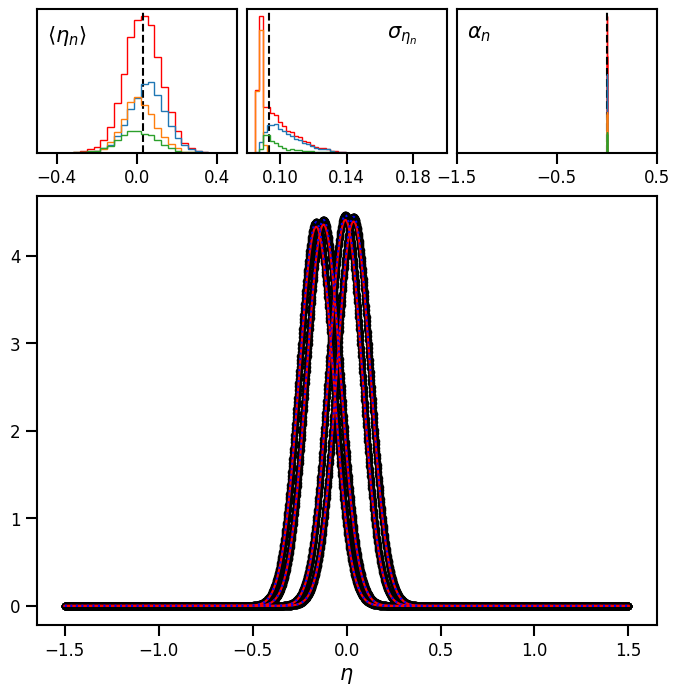

In [2]:
mpl.rcParams['axes.linewidth'] = 1.5

def skew_normal(x, loc, scale, alpha):
    def std_normal(x):
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    
    def cdf(x):
        return 0.5 * (1 + erf(x / np.sqrt(2)))
    
    return (2 / scale) * std_normal((x - loc) / scale) * cdf(alpha * (x - loc) / scale) * 0.988

fp_fit = "ALL_COMBINED"
fp_fit_method = 0

# Candidate log-distance ratios
dmin, dmax, nd = -1.5, 1.5, 2001
dbins = np.linspace(dmin, dmax, nd, endpoint=True)

# Differentiate 3 survey colors
colors = ["C0", "C1", "C2"]

# Create a figure
a_ = 8
fig = plt.figure(figsize=(a_ , a_ ))
NBINS = 25

# Create a GridSpec with 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 3], wspace=0.05, hspace=0.15)

# First axis: edge-on FP (r_obs vs r_pred)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
ax4 = fig.add_subplot(gs[1, :])


# Histograms of logdist parameters
df_combined = pd.DataFrame()
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"./{survey.lower()}.csv")
    df_combined = pd.concat([df_combined, df], axis=0)

logdist_mean_bins = np.linspace(df_combined["logdist_mean_all_combined"].min(), df_combined["logdist_mean_all_combined"].max(), NBINS)
logdist_scale_bins = np.linspace(df_combined["logdist_scale_all_combined"].min(), df_combined["logdist_scale_all_combined"].max(), NBINS)
logdist_alpha_bins = np.linspace(df_combined["logdist_alpha_all_combined"].min(), df_combined["logdist_alpha_all_combined"].max(), NBINS)
ax1.hist(df_combined["logdist_all_combined"], bins=logdist_mean_bins, histtype="step", color='r')
ax2.hist(df_combined["logdist_err_all_combined"], bins=logdist_scale_bins, histtype="step", color='r')
ax3.hist(df_combined["logdist_alpha_all_combined"], bins=logdist_alpha_bins, histtype="step", color='r')
ax1.axvline(df_combined["logdist_all_combined"].quantile(0.5), c='k', ls="--")
ax2.axvline(df_combined["logdist_err_all_combined"].quantile(0.5), c='k', ls="--")
ax3.axvline(df_combined["logdist_alpha_all_combined"].quantile(0.5), c='k', ls="--")


for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"./{survey.lower()}.csv")
    ax1.hist(df["logdist_all_combined"], bins=logdist_mean_bins, histtype="step")
    ax2.hist(df["logdist_err_all_combined"], bins=logdist_scale_bins, histtype="step")
    ax3.hist(df["logdist_alpha_all_combined"], bins=logdist_alpha_bins, histtype="step")
    df_combined = pd.concat([df_combined, df], axis=0)

# Ax4: worst posteriod PDFs
for i, survey in enumerate(["6dFGS", "LAMOST"]):
    # Load posterior pdf
    posterior_pdfs = np.load(f"./{survey.lower()}_pdf.npy")

    # Load worst PDFs
    df = pd.read_csv(f"./{survey.lower()}.csv")
    df_worst = df
    df_worst = df_worst.sort_values(by=f'logdist_rmse_{fp_fit.lower()}', ascending=False).head(2)
    worst_index = list(df_worst.index)
    print(f"{survey} | {worst_index}")
    logdist = df_worst[f"logdist_{fp_fit.lower()}"].tolist()
    logdist_err = df_worst[f"logdist_err_{fp_fit.lower()}"].tolist()
    loc_ = df_worst[f"logdist_loc_{fp_fit.lower()}"].tolist()
    scale_ = df_worst[f"logdist_scale_{fp_fit.lower()}"].tolist()
    alpha_ = df_worst[f"logdist_alpha_{fp_fit.lower()}"].tolist()

    for j, idx in enumerate(worst_index):
        # ax4.axvline(x=logdist[j])
        ax4.plot(dbins, skew_normal(dbins, loc=loc_[j], scale=scale_[j], alpha=alpha_[j]), c='r')
        ax4.plot(dbins, norm.pdf(dbins, loc=logdist[j], scale=logdist_err[j]), c='blue', ls=":")
        y = posterior_pdfs[idx]
        ax4.scatter(dbins, y, s=20, c='k')

# Remove y labels for histograms
labels_ = [r"$\langle \eta_n \rangle$", r"$\sigma_{\eta_n}$", r"$\alpha_n$"]
for i, ax in enumerate([ax1, ax2, ax3]):
    xloc = 0.05
    if i == 1:
        xloc = 0.7
    ax.set_yticks([])
    ax.tick_params(left=False)
    ax.text(xloc, 0.90, labels_[i], transform=ax.transAxes, fontsize=15, 
         verticalalignment='top', horizontalalignment='left')
ax4.set_xlabel(r"$\eta$", fontsize=15)

for i, ax in enumerate(fig.axes):
    ax.tick_params(axis='both', which='major', labelsize=12)

# Custom plot configs
ax1.set_xlim(-0.5, 0.5)
ax1.set_xticks([-0.4, 0, 0.4])

ax2.set_xlim(0.08, 0.2)
ax2.set_xticks([0.1, 0.14, 0.18])

ax3.set_xticks([-1.5, -0.5, 0.5,])

for ax in fig.axes:
    ax.tick_params(axis='both', which='major', length=8, width=1.5)

# fig.savefig('../img/final_plot/fig_10_logdist_distributions.pdf', bbox_inches='tight', dpi=300)

In [6]:
df["logdist_alpha_all_combined"].sort_values(ascending=True)

336    -0.000216
33     -0.000214
1598   -0.000163
506    -0.000159
1016   -0.000158
          ...   
946     0.000151
713     0.000160
1810    0.000160
385     0.000163
701     0.000184
Name: logdist_alpha_all_combined, Length: 2142, dtype: float64